Accuracy: 56.220000000000006%
Mean loss: 0.7233730887102542
Done epoch : 1
Accuracy: 56.220000000000006%
Mean loss: 0.697507537028295
Done epoch : 2
Accuracy: 56.220000000000006%
Mean loss: 0.6895575726732058
Done epoch : 3
Accuracy: 56.220000000000006%
Mean loss: 0.6872450111907785
Done epoch : 4
Accuracy: 56.220000000000006%
Mean loss: 0.6865865884359749
Done epoch : 5


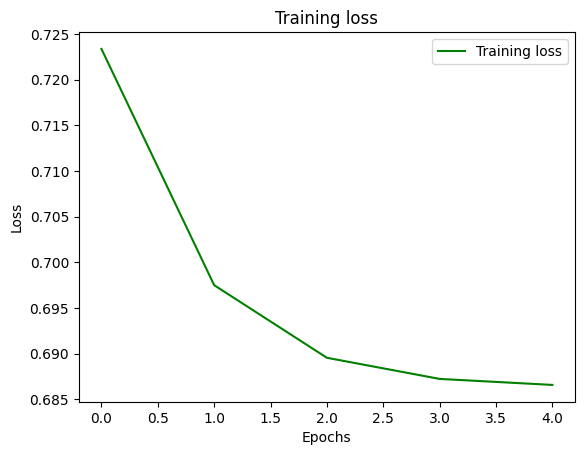

In [15]:
import math
import matplotlib.pyplot as plt
import random
from data import load_synth
(x_train, t_train), (x_val, t_val), num_cls = load_synth()

def sigmoid(x):
    return [1 / (1 + (math.exp(-x[i]))) for i in range(len(x))]

def softmax(outputs):
    denominator = sum(math.exp(o) for o in outputs)
        
    if denominator == 0:
        return 0
    
    return [math.exp(outputs[j]) / denominator for j in range(len(outputs))]

def d_sigmoid(x):
    s = sigmoid(x)
    return [s[i] * (1 - s[i]) for i in range(len(x))]

def cross_entropy(predictions, targets):
    loss = 0
    m = len(predictions)
    
    for j in range(m):
        loss += targets[j] * math.log(predictions[j])
    
    return -1 * loss

def lin(inputs, weights, bias):
    outputs = [0] * len(weights[0])
    for n in range(len(weights[0])): # num of next layer neurons
        for i in range(len(inputs)):
            outputs[n] += inputs[i] * weights[i][n]
        outputs[n] += bias[n]
    return outputs

def lin_grad(lin_input, output_grad, weights):
    
    dW = [[0] * len(weights[0]) for _ in range(len(weights))]
    dx = [0] * len(lin_input)

    for n in range(len(weights[0])):
        for i in range(len(lin_input)):
            dW[i][n] = output_grad[n] * lin_input[i]
            dx[i] += output_grad[n] * weights[i][n]
    
    db = output_grad.copy()
    
    return dW, dx, db

def d_cross_entropy(predictions, targets):
    # dl_do = dl_dy * dy_do
    # dl_dy = deriv of cross entropy
    # dy_do = deriv of softmax
    # deriv of loss wrt to o
    return [predictions[i] - targets[i] for i in range(len(targets))] 


# minmax scaler
def normalize(v, ma, mi): 
    norm = [(v[i] - mi) / (ma - mi) for i in range(len(v))]
    return norm

ma = x_train.max()
mi = x_train.min()
x_train_normize = normalize(x_train, ma, mi)

r_t_val = t_val.reshape((t_val.shape[0], 1))
x_val_normize = normalize(x_val, ma, mi)

def one_hot(arr):
    max_val = max(arr)
    new_arr = [[0] * (max_val + 1) for _ in range(len(arr))]
    
    for i in range(len(arr)):
        new_arr[i][arr[i]] = 1
    
    return new_arr

def add_matrix(a, b):
    c = [[0] * len(a[0]) for _ in range(len(a))]
    for i in range(len(a)):
        for j in range(len(a[0])):
            c[i][j] += a[i][j] + b[i][j]    
    return c

def sgd_matrix(W, a_dW, lr):
    for i in range(len(W)):
        for j in range(len(W[0])):
            W[i][j] += -lr * a_dW[i][j]   
    return W
    
t_train_one_hot = one_hot(t_train)
t_val_one_hot = one_hot(t_val)

# hyperparameters
lr = 1e-5
size_layer_1 = 3
size_layer_2 = 2
epoch = 5

num_of_input = 2

W = []
for _ in range(num_of_input):
    row = [random.uniform(-1, 1) for _ in range(size_layer_1)]
    W.append(row)
V = []
for _ in range(size_layer_1):
    row = [random.uniform(-1, 1) for _ in range(size_layer_2)]
    V.append(row)
  
b = [0] * size_layer_1  
c = [0] * size_layer_2

len_train =  len(x_train_normize)
losses = []

# training loop
for e in range(epoch):
    a_dW = [[0] * size_layer_1 for _ in range(num_of_input)]
    a_dV = [[0] * size_layer_2 for _ in range(size_layer_1)]
    a_db = [0] * size_layer_1
    a_dc = [0] * size_layer_2
    
    loss = []
    
    for j in range(len_train):
        
        x = x_train_normize[j]
        t = t_train_one_hot[j]
        
        # forward
        k = lin(x, W, b)
        h = sigmoid(k)
        o = lin(h, V, c)
        y = softmax(o)
        
        l = cross_entropy(y, t)
        loss.append(l)
        
        # backward
        do = d_cross_entropy(y, t)
        dV, dh, dc = lin_grad(h, do, V)
        dk = d_sigmoid(k)
        dk = [dh[i] * dk[i] for i in range(len(dh))]
        dW, dx, db = lin_grad(x, dk, W)
        
        # accumulate gradients
        a_dW = add_matrix(a_dW, dW)
        a_dV = add_matrix(a_dV, dV)
        a_db = [a_db[i] + db[i] for i in range(len(a_db))]
        a_dc = [a_dc[i] + dc[i] for i in range(len(a_dc))]
    
    # sgd - after each epoch
    W = sgd_matrix(W, a_dW, lr)
    V = sgd_matrix(V, a_dV, lr)
    b = [b[i] + -lr * a_db[i] for i in range(len(b))]
    c = [c[i] + -lr * a_dc[i] for i in range(len(c))]
    
    mean_loss = sum(loss) / len(loss)
    losses.append(mean_loss)
    
    # test on validation set

    len_val =  len(x_val_normize)
    correct = 0
    
    val_loss = []
    for i in range(len_val):
        t = t_val_one_hot[i]
        x = x_val_normize[i]

        k = lin(x, W, b)
        h = sigmoid(k)
        o = lin(h, V, c)
        y = softmax(o)
        
        l = cross_entropy(y, t)
        val_loss.append(l)
        
        if argmax(y) == argmax(t):
            correct += 1
            
    # val_mean_loss = math.mean (val_loss)
    # val_losses.append(val_mean_loss)
    
    acc = correct/len_val
    # accuracies.append(acc)
    
    print(f'Accuracy: {(acc) * 100}%')
    print(f'Mean loss: {(mean_loss)}')
    
    print(f'Done epoch : {e+1}')

def plot_losses(loss_train):
    epochs = range(0,len(loss_train))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses(losses)

In [4]:
def argmax(arr):
    return max((val, idx) for idx, val in enumerate(arr))[1]

t_test_one_hot = one_hot(t_val)
x_test_normize = normalize(x_val, ma, mi)

len_test =  len(x_test_normize)
correct = 0

for i in range(len_test):
    t = t_test_one_hot[i]
    x = x_test_normize[i]

    k = lin(x, W, b)
    h = sigmoid(k)
    o = lin(h, V, c)
    y = softmax(o)
    
    if argmax(y) == argmax(t):
        correct += 1

print(f'Accuracy: {(correct/len_test) * 100}%')

Accuracy: 56.220000000000006%


In [8]:
x = [1,2,3]
y = [2, 2, 3]
x + y

[1, 2, 3, 2, 2, 3]